# Problem Statement

Consider a cost function $$c(x) = \sum^{n-1}_{i,j=0} x_i w_{ij} x_j \qquad,$$ where $x_i$ is a component of a binary vector $\textbf{x}$ and $i,j = 0,1,...,n-1$ with $n=7$. The matrix $W = [w_{ij}]$ is given by:
$$\begin{bmatrix}
-3 & 2 & -9 & 3 & -7 & 1 & -1\\
8 & -5 & 6 & -7 & -3 & 8 & 8\\
7 & 6 & -4 & -5 & 3 & -3 & -2\\
-2 & 3 & -9 & 0 & -4 & 2 & -8\\
6 & 3 & -5 & 1 & -2 & -5 & 9\\
9 & 4 & -8 & 0 & -2 & 7 & 8\\
-5 & 1 & 3 & 3 & -2 & -9 & 7
\end{bmatrix}$$

1. Write a classical algorithm to find a global minimum of the cost function over all the $n$-component binary vectors.
2. Write a quantum algorithm to find a global minimum of the cost function over all the $n$-component binary vectors.

***
# Solution(s)
 
Presented in the notebook below are three(-ish) kinds of solutions for the posed ***QUBO (Quadratic Unconstrained Binary Optimisation)*** problem:
- one classical brute force solution, and 
- two quantum-based solutions:
    - one using DWave's quantum-anneling QPUs, and the other 
    - using the gate-model IBM quantum computers.
- and another small classical solution using the simplex method, as available through the CPLEX optimiser provided by Qiskit itself.

Initial observation: The posed cost function is quadratic in the variables $x_i$, and has no inequality or equality constraints, but has the requirement that the variables $x_i$ are binary.

Initial Thoughts:

1.
- My very first rudimentary ideas regarding a classical algorithm, apart from brute force were to consider approaches like ***Gradient Descent***, or the ***Simplex Method*** (since the objective function's form *looks* convex), or some kind of ***genetic algorithm***.
- The first two considerations were shot down quickly since, first, Gradient Descent is applicable only to differentiable functions, but the requirement of vectors being binary breaks differentiability, so we can't use GD as it is. 
- On the other hand, I had studied Simplex Method in the context of optimising *Linear* Programming Problems, which this cost function is evidently not. Also, while the cost function's form *looks* convex it's not a convex function because of the binary requirement on the vectors. 
    - Turns out, I learnt later that the Simplex method *can* be used to solve this quadratic problem, by first casting it into a linear programming problem with constraints.
- I was familiar with genetic algorithms which are heuristic algorithms that *search* the solution space for good solutions by "generating" a certain subset solutions, producing "good" offspring solutions, and "evolving" the population of considered solutions towards optimality.
    - This turned out to be similar in spirit to the **Tabu Search** algorithm, that I late discovered.
2.
- On the quantum aspect, the immediate consideration was of variational quantum(-classical hybrid) algorithms, like ***VQE***, or ***QAOA***. A quick look into some old Qiskit material revealed that the problem posed is rather an important model for computation using quantum-annealing methods, widely known in literature as a ***QUBO (Quadratic Unconstrained Binary Optimisation)*** problem. **A QUBO is equivalent to an Ising model, which immediately makes it quite tractable to simulate using annealing methods**. On annealing based quantum systems such as DWave's QPUs, the solution to such problems is rather directly reflected in the quantum-mechanical process. Instead, on gate-model based quantum computers such as those available through IBM's `Qiskit` Python library, the QAOA (Quantum Approximate Optimization Algorithm) is a *hybrid* algorithm inspired from both quantum annealing and classical iterative algorithms to solve QUBOs. QAOA itself can be seen as a special case of the ***VQE (Variational Quantum Eigensolver)***.

Below, we take a look at some programmed solution implementations, through high-level APIs as provided by libraries provided by DWave and Qiskit. I provide very brief explanations on the most important aspects of the logical internals necessary for the program, while deferring more detailed explanations to a further session (say, in-person).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dwave.system import EmbeddingComposite, DWaveSampler
from dimod import BinaryQuadraticModel

## Brute Force Solution

It's indicative to look at the brute force solution for this smaller, tractable problem in order to have a baseline of guaranteed correctness against which we can vet subsequent solutions.

In [2]:
########################  Brute Force solution ######################## 

#####----------Setting up the problem----------
N = 7
num_states = 2**N

def get_binary(n: int)->np.array:
    """
    Returns the bitstring representation of the passed integer parameter n
    """
    binary_form = []
    while(n != 0):
        binary_form = [(1 if (n & 1) >= 1 else 0)] + binary_form
        n = n >> 1
    return np.array(binary_form)

def pad_to_fit(arr):
    return np.pad(arr, (N-arr.size,0),'constant', constant_values=0)

### . . . generating all the possible binary vectors . . .
possible_states = np.array([i for i in range(num_states)])
possible_states = list(map( get_binary, possible_states))
possible_states[0] = np.array([0])
possible_states = list(map(pad_to_fit, possible_states))

### . . . setting up the given weight matrix . . .
W = np.array([-3, 2, -9, 3, -7, 1, -1, 8, -5, 6, -7, -3, 8, 8, 7, 6, -4, -5, 3, -3, -2,-2, 3, -9, 0, -4, 2, -8, 6, 3, -5, 1, -2, -5, 9, 9,4, -8, 0, -2, 7, 8, -5, 1, 3, 3, -2, -9, 7])
W = W.reshape((7,7))
print(W)

symmetricW = 0.5 * (W + W.T)        #symmetrising the matrix, just to put it in the form usually met in literature
print(symmetricW)

#####---------Finding the minimum-----------
min_state = {"idx_of_min": 0, "min_energy": 2**31}
energies = []
for i,v in enumerate(possible_states):
    energy = v.T @ symmetricW @ v
    energies.append(energy)
    if energy < min_state["min_energy"]:
        min_state["idx_of_min"] = i
        min_state["min_energy"] = energy

print(f'The minimum cost: {min_state["min_energy"]} is attained for the binary-vector {possible_states[min_state["idx_of_min"]]}')

[[-3  2 -9  3 -7  1 -1]
 [ 8 -5  6 -7 -3  8  8]
 [ 7  6 -4 -5  3 -3 -2]
 [-2  3 -9  0 -4  2 -8]
 [ 6  3 -5  1 -2 -5  9]
 [ 9  4 -8  0 -2  7  8]
 [-5  1  3  3 -2 -9  7]]
[[-3.   5.  -1.   0.5 -0.5  5.  -3. ]
 [ 5.  -5.   6.  -2.   0.   6.   4.5]
 [-1.   6.  -4.  -7.  -1.  -5.5  0.5]
 [ 0.5 -2.  -7.   0.  -1.5  1.  -2.5]
 [-0.5  0.  -1.  -1.5 -2.  -3.5  3.5]
 [ 5.   6.  -5.5  1.  -3.5  7.  -0.5]
 [-3.   4.5  0.5 -2.5  3.5 -0.5  7. ]]
The minimum cost: -34.0 is attained for the binary-vector [0 0 1 1 1 1 0]


Text(0.5, 1.0, '$x^T W x$ vs $x (\\in \\{0,1\\}^7)$')

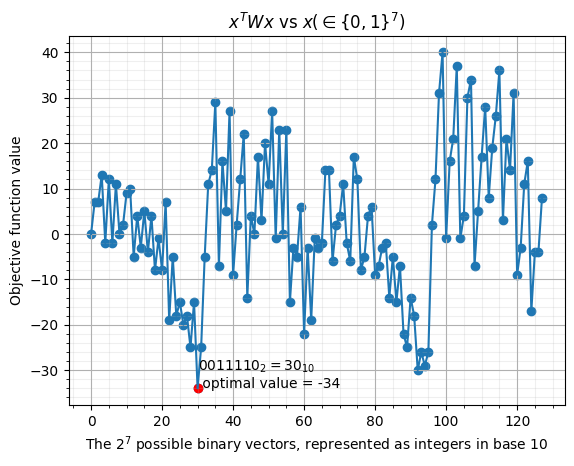

In [3]:
plt.scatter([i for i in range(128)], energies)
plt.plot([i for i in range(128)], energies)
plt.grid(which='minor', alpha=0.2, markevery = 5.0)
plt.grid(which='major')
plt.minorticks_on()
plt.scatter( int(np.where(energies == min(energies))[0][0]), min(energies), color='red')
plt.annotate( f'{"".join(str(x) for x in (possible_states[min_state["idx_of_min"]]))}$_2 = {min_state["idx_of_min"]}_{"{10}"}$ \n optimal value = -34 ', (int(np.where(energies == min(energies))[0][0]), min(energies)))
plt.xlabel("The $2^7$ possible binary vectors, represented as integers in base 10")
plt.ylabel("Objective function value")
plt.title('$x^T W x$ vs $x (\in \{0,1\}^7)$')

***
## Quantum-Annealing Solution using DWave QPU

The code in this section invokes a DWave Quantum Processing Unit (QPU) to optimise our QUBO problem via annealing. The provided API internally converts the QUBO to an Ising Hamiltonian, so we don't need to do it explicitly.

In [4]:
### . . . . Converting the weight matrix W to a dictionary in the form needed by DWave's 'sampler' . . . .
Q = {}
# Q_named = {}
for i in range(N):
    for j in range(N):
        Q[(i,j)] = symmetricW[i,j]
        # Q_named[(f'x_{i}',f'x_{j}')] = symmetricW[i,j]

Q

{(0, 0): np.float64(-3.0),
 (0, 1): np.float64(5.0),
 (0, 2): np.float64(-1.0),
 (0, 3): np.float64(0.5),
 (0, 4): np.float64(-0.5),
 (0, 5): np.float64(5.0),
 (0, 6): np.float64(-3.0),
 (1, 0): np.float64(5.0),
 (1, 1): np.float64(-5.0),
 (1, 2): np.float64(6.0),
 (1, 3): np.float64(-2.0),
 (1, 4): np.float64(0.0),
 (1, 5): np.float64(6.0),
 (1, 6): np.float64(4.5),
 (2, 0): np.float64(-1.0),
 (2, 1): np.float64(6.0),
 (2, 2): np.float64(-4.0),
 (2, 3): np.float64(-7.0),
 (2, 4): np.float64(-1.0),
 (2, 5): np.float64(-5.5),
 (2, 6): np.float64(0.5),
 (3, 0): np.float64(0.5),
 (3, 1): np.float64(-2.0),
 (3, 2): np.float64(-7.0),
 (3, 3): np.float64(0.0),
 (3, 4): np.float64(-1.5),
 (3, 5): np.float64(1.0),
 (3, 6): np.float64(-2.5),
 (4, 0): np.float64(-0.5),
 (4, 1): np.float64(0.0),
 (4, 2): np.float64(-1.0),
 (4, 3): np.float64(-1.5),
 (4, 4): np.float64(-2.0),
 (4, 5): np.float64(-3.5),
 (4, 6): np.float64(3.5),
 (5, 0): np.float64(5.0),
 (5, 1): np.float64(6.0),
 (5, 2): np.float6

In [5]:
### . . . . Converting the problem to a BQM (Binary Quadratic Model) . . . .
bqm = BinaryQuadraticModel.from_qubo(Q)

### . . . Defining the sampler that will be used to run the problem . . .
sampler = EmbeddingComposite(DWaveSampler())

### . . Running the problem on the sampler and printing the results . . 
num_reads = 10
sampleset = sampler.sample(bqm,
                           num_reads = num_reads,
                           label='LTIMindTree Optimisation Question')
print(sampleset)

   0  1  2  3  4  5  6 energy num_oc. chain_.
0  0  0  1  1  1  1  0  -34.0      10     0.0
['BINARY', 1 rows, 10 samples, 7 variables]


The DWave qpu sampler returns the most sampled state as the correct solution, same as the brute force one.

***
## QAOA using Qiskit

The Qiskit QAOA implementations require the QUBO to first be mapped to its equivalent Ising Hamiltonian. The required transformation is simple, via the substitution $$x_i = \frac{1}{2}(\mathbb{I - Z_i}) \qquad,$$ where $\mathbb{I} \equiv \mathbb{I}^{\otimes n}$ is the identity matrix of appropriate dimensions, and $\mathbb{Z_i} = \mathbb{I_0}\otimes\mathbb{I_1}\otimes..\mathbb{\sigma^z_i}..\otimes\mathbb{I_n}$ is the single-qubit pauli matrix $\sigma_z$ applied to the $i^{th}$ qubit.

In the program below, I perform this conversion to the Ising Hamiltonian programmatically using one of Qiskit's methods itself.

Internally, the QAOA circuit defines a *parametric* quantum circuit with tunable parameters $\{\beta_i\}$ and $\{\gamma_i\}$ that produces a quantum state $\vert\psi(\{\beta_i,\gamma_i\})\rangle$—which is used to produce an output as the expectation value $\langle\psi({\beta_i,\gamma_i})\vert H \vert\psi({\beta_i,\gamma_i})\rangle$ of the problem's mapped Ising Hamiltonian $H$. In the program below, I've defined a QAOA circuit with `reps`=50 parameters, both $\beta$ and $\gamma$ each, i.e. a total of 100 parameters. This number of reps was found to be good through trial and error, to fully optimise the cost. Lower reps of 3 (as usually provided in tutorials), or even 30 were found to be insufficient for finding the optimal value.

This output from the quantum circuit is fed to a classical optimiser—in this case chosen to be ***COBYLA (Constrained Optimisation BY Linear Approximation)***, which iterates through this process of fetching the quantum circuit's output and tweaking the parameters, until an optimal set of parameters $\{\beta^*_i, \gamma^*_i\}$ is obtained.

The code in this section is implemented through Qiskit's quantum simulators.

In [6]:
### . . . First, converting the weight matrix to a dictionary mapping the diagonal elements to "linear" coefficients, 
###       and non-diagonal elements to "quadratic" coefficients in the cost function, along with a constant term . . .
Q_with_separate_dicts = ({}, {}, 0)
for i in range(N):
    for j in range(N):
        if i!=j:
            Q_with_separate_dicts[1][(f'x_{i}',f'x_{j}')] = symmetricW[i,j]
        else:
            Q_with_separate_dicts[0][f'x_{i}'] = symmetricW[i, j]

Q_with_separate_dicts

({'x_0': np.float64(-3.0),
  'x_1': np.float64(-5.0),
  'x_2': np.float64(-4.0),
  'x_3': np.float64(0.0),
  'x_4': np.float64(-2.0),
  'x_5': np.float64(7.0),
  'x_6': np.float64(7.0)},
 {('x_0', 'x_1'): np.float64(5.0),
  ('x_0', 'x_2'): np.float64(-1.0),
  ('x_0', 'x_3'): np.float64(0.5),
  ('x_0', 'x_4'): np.float64(-0.5),
  ('x_0', 'x_5'): np.float64(5.0),
  ('x_0', 'x_6'): np.float64(-3.0),
  ('x_1', 'x_0'): np.float64(5.0),
  ('x_1', 'x_2'): np.float64(6.0),
  ('x_1', 'x_3'): np.float64(-2.0),
  ('x_1', 'x_4'): np.float64(0.0),
  ('x_1', 'x_5'): np.float64(6.0),
  ('x_1', 'x_6'): np.float64(4.5),
  ('x_2', 'x_0'): np.float64(-1.0),
  ('x_2', 'x_1'): np.float64(6.0),
  ('x_2', 'x_3'): np.float64(-7.0),
  ('x_2', 'x_4'): np.float64(-1.0),
  ('x_2', 'x_5'): np.float64(-5.5),
  ('x_2', 'x_6'): np.float64(0.5),
  ('x_3', 'x_0'): np.float64(0.5),
  ('x_3', 'x_1'): np.float64(-2.0),
  ('x_3', 'x_2'): np.float64(-7.0),
  ('x_3', 'x_4'): np.float64(-1.5),
  ('x_3', 'x_5'): np.float64(1.0

In [7]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators.docplex_mp import to_docplex_mp

In [8]:
### . . . Defining a `Quadratic Program` object that captures the definition of our QUBO . . .
qp_qubo = QuadraticProgram("My QUBO")
qp_qubo.binary_var_list([f'_{i}' for i in range(N)])
qp_qubo.minimize(linear=Q_with_separate_dicts[0], quadratic=Q_with_separate_dicts[1],constant=Q_with_separate_dicts[2])
print(qp_qubo.prettyprint())

### . . . Converting the QUBO to its corresponding Ising Hamiltonian . . .
qp = qp_qubo.to_ising()
print(f"The Ising Hamiltonian corresponding to the QUBO is:\n\n \
\t In Sparse Puali Operator format: \n{qp} \n\n \t In dense matrix format: \n {qp[0].to_matrix()}\nshape:{qp[0].to_matrix().shape}")

Problem name: My QUBO

Minimize
  10*x_0*x_1 - 2*x_0*x_2 + x_0*x_3 - x_0*x_4 + 10*x_0*x_5 - 6*x_0*x_6
  + 12*x_1*x_2 - 4*x_1*x_3 + 12*x_1*x_5 + 9*x_1*x_6 - 14*x_2*x_3 - 2*x_2*x_4
  - 11*x_2*x_5 + x_2*x_6 - 3*x_3*x_4 + 2*x_3*x_5 - 5*x_3*x_6 - 7*x_4*x_5
  + 7*x_4*x_6 - x_5*x_6 - 3*x_0 - 5*x_1 - 4*x_2 - 2*x_4 + 7*x_5 + 7*x_6

Subject to
  No constraints

  Binary variables (7)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6

The Ising Hamiltonian corresponding to the QUBO is:

 	 In Sparse Puali Operator format: 
(SparsePauliOp(['IIIIIIZ', 'IIIIIZI', 'IIIIZII', 'IIZIIII', 'IZIIIII', 'ZIIIIII', 'IIIIIZZ', 'IIIIZIZ', 'IIIZIIZ', 'IIIZIII', 'IIZIIIZ', 'IZIIIIZ', 'ZIIIIIZ', 'IIIIZZI', 'IIIZIZI', 'IZIIIZI', 'ZIIIIZI', 'IIIZZII', 'IIZIZII', 'IZIIZII', 'ZIIIZII', 'IIZZIII', 'IZIZIII', 'ZIIZIII', 'IZZIIII', 'ZIZIIII', 'ZZIIIII'],
              coeffs=[-1.5 +0.j, -7.25+0.j,  6.  +0.j,  2.5 +0.j, -4.75+0.j, -4.75+0.j,
  2.5 +0.j, -0.5 +0.j,  0.25+0.j,  5.75+0.j, -0.25+0.j,  2.5 +0.j,
 -1.5 +0.j,  3.  +0.j, -1.  +0.

### Classical segue

The cell below runs a classical Simplex method implemented in C (as per information available from Wiki), provided through the CPLEX library.

In [14]:
from qiskit_optimization.algorithms import CplexOptimizer

cplex_optimizer = CplexOptimizer()

result_orig = cplex_optimizer.solve(qp_qubo)
print(f"The optimal vector is: {result_orig.x}")
result_orig.prettyprint()

The optimal vector is: [0. 0. 1. 1. 1. 1. 0.]


'objective function value: -34.0\nvariable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=1.0, x_5=1.0, x_6=0.0\nstatus: SUCCESS'

### Back to quantum...

In [15]:
from qiskit.primitives import Sampler
from qiskit.quantum_info import Pauli
from qiskit.result import QuasiDistribution

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

from qiskit_algorithms.utils import algorithm_globals

sampler = Sampler()

def bitfield(n, L):
    """
    Converts the integer n into its L-length bitstring representation, returned as a list of digits
    """
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

def sample_most_likely(state_vector):
    """
    Computes the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.
    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

algorithm_globals.random_seed = 10598

### . . COBYLA (Constrained Optimisation BY Linear Approximation) is a "gradient-free" optimisation algorithm
###     available through the `scipy` library.
optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=50)

result = qaoa.compute_minimum_eigenvalue(qp[0])

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by QAOA is {x.T @ symmetricW @ x}")

/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_40617/345105329.py:10: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


[0 0 1 1 1 1 0]
Objective value computed by QAOA is -34.0


In [16]:
print(f"The optimal parameters obtained for the quantum circuit were: \n {result.optimal_point}")
result.optimal_parameters

The optimal parameters obtained for the quantum circuit were: 
 [-0.19297017 -5.64609907  0.26535022  1.68299448  0.0132269  -1.88869593
 -4.18247339 -1.8207876   6.16579399 -3.48498631  5.59290301  4.55581444
 -2.81887586  3.08360652 -1.76918006  0.87634045  7.04488185  3.47222578
 -0.94524297  4.10734509  5.48656496  0.97504688 -2.42469237 -0.55809743
  0.34091344 -1.27550306  2.15235984 -5.88035071  2.54162583 -6.03935901
 -0.25490116 -4.99575721 -0.57902861  3.20982294  3.74937462 -6.20988926
  0.52791743  2.50494046 -4.91806813  5.34218848  3.86476353 -5.75177708
 -4.09402543  1.44447074  6.24701529 -5.55093427  3.54821863  4.92940644
  1.63929055 -3.3391229   5.31043387 -5.0999575  -3.5732673  -1.93448704
  2.35493971  5.88846934  0.16447661 -0.18819484  1.42564363 -2.14575425
  2.40851377  1.5317291  -5.62535261 -3.84350189  6.20300185  2.37075708
 -3.5992572  -5.95069327  6.06026379 -1.1504444  -0.60512412  0.53400091
  1.45974865 -2.41808901 -3.35215716  5.72720348  4.48678824

{ParameterVectorElement(β[0]): np.float64(-0.19297017089374766),
 ParameterVectorElement(β[1]): np.float64(-5.646099072607616),
 ParameterVectorElement(β[2]): np.float64(0.2653502205332618),
 ParameterVectorElement(β[3]): np.float64(1.6829944764819529),
 ParameterVectorElement(β[4]): np.float64(0.013226902813130803),
 ParameterVectorElement(β[5]): np.float64(-1.8886959318342154),
 ParameterVectorElement(β[6]): np.float64(-4.182473385345846),
 ParameterVectorElement(β[7]): np.float64(-1.8207875966640497),
 ParameterVectorElement(β[8]): np.float64(6.165793988863071),
 ParameterVectorElement(β[9]): np.float64(-3.4849863080391863),
 ParameterVectorElement(β[10]): np.float64(5.592903010121357),
 ParameterVectorElement(β[11]): np.float64(4.555814443592576),
 ParameterVectorElement(β[12]): np.float64(-2.8188758564469945),
 ParameterVectorElement(β[13]): np.float64(3.0836065188696558),
 ParameterVectorElement(β[14]): np.float64(-1.7691800555124508),
 ParameterVectorElement(β[15]): np.float64(0

## QAOA run on IBM QPU using the optimal parameters

In this section, we run the measurement of the expectation value from the optimal parametric circuit on an actual IBM QPU. We first need to transpile our circuit to the specific quantum computer we aim to run our job on, and then we send a 'sampling' job to the QPU. In this case, I've opted to run the job on IBM Kyoto.

In [17]:
from qiskit.quantum_info import Pauli, SparsePauliOp

cost_hamiltonian = qp[0]
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIZ', 'IIIIIZI', 'IIIIZII', 'IIZIIII', 'IZIIIII', 'ZIIIIII', 'IIIIIZZ', 'IIIIZIZ', 'IIIZIIZ', 'IIIZIII', 'IIZIIIZ', 'IZIIIIZ', 'ZIIIIIZ', 'IIIIZZI', 'IIIZIZI', 'IZIIIZI', 'ZIIIIZI', 'IIIZZII', 'IIZIZII', 'IZIIZII', 'ZIIIZII', 'IIZZIII', 'IZIZIII', 'ZIIZIII', 'IZZIIII', 'ZIZIIII', 'ZZIIIII'],
              coeffs=[-1.5 +0.j, -7.25+0.j,  6.  +0.j,  2.5 +0.j, -4.75+0.j, -4.75+0.j,
  2.5 +0.j, -0.5 +0.j,  0.25+0.j,  5.75+0.j, -0.25+0.j,  2.5 +0.j,
 -1.5 +0.j,  3.  +0.j, -1.  +0.j,  3.  +0.j,  2.25+0.j, -3.5 +0.j,
 -0.5 +0.j, -2.75+0.j,  0.25+0.j, -0.75+0.j,  0.5 +0.j, -1.25+0.j,
 -1.75+0.j,  1.75+0.j, -0.25+0.j])


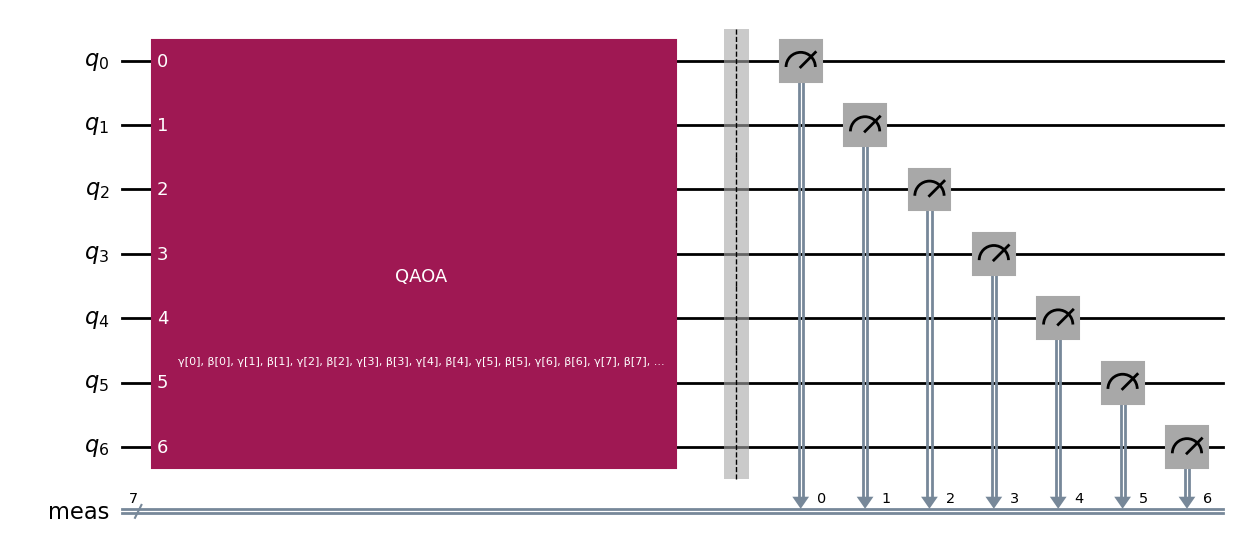

In [18]:
from qiskit.circuit.library import QAOAAnsatz
reps = 50
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit.measure_all()

circuit.draw('mpl')

In [19]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(β[8]), ParameterVectorElement(β[9]), ParameterVectorElement(β[10]), ParameterVectorElement(β[11]), ParameterVectorElement(β[12]), ParameterVectorElement(β[13]), ParameterVectorElement(β[14]), ParameterVectorElement(β[15]), ParameterVectorElement(β[16]), ParameterVectorElement(β[17]), ParameterVectorElement(β[18]), ParameterVectorElement(β[19]), ParameterVectorElement(β[20]), ParameterVectorElement(β[21]), ParameterVectorElement(β[22]), ParameterVectorElement(β[23]), ParameterVectorElement(β[24]), ParameterVectorElement(β[25]), ParameterVectorElement(β[26]), ParameterVectorElement(β[27]), ParameterVectorElement(β[28]), ParameterVectorElement(β[29]), ParameterVectorElement(β[30]), ParameterVectorElement(β[31]), Par

In [21]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_quantum", token="759b2566f9330106e9ae60c8e33be99d21c69834d8e23c8b32be6b9ce95ea66f8be63b304337a58453a9e8e77e1cd9d4f3490b7282a56c3ac316e786f4839eec", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy(min_num_qubits=127)
backend = service.backend(name='ibm_kyoto')
print(backend)

<IBMBackend('ibm_kyoto')>


In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeKyoto
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

# fakebackend = FakeBrisbane()
fakebackend = FakeKyoto()

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=fakebackend)

candidate_circuit = pm.run(circuit)

In [24]:
optimized_circuit = candidate_circuit.assign_parameters(result.optimal_point)
# optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [ ]:
# candidate_circuit.draw('mpl', fold=True, idle_wires=False)
# candidate_circuit.draw(fold=True, idle_wires=False)

In [25]:

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{2: 0.0073, 114: 0.0092, 66: 0.0079, 64: 0.0066, 52: 0.0087, 41: 0.0075, 30: 0.0083, 28: 0.0075, 59: 0.0072, 47: 0.0078, 10: 0.0063, 125: 0.0071, 76: 0.0085, 50: 0.0071, 117: 0.0089, 96: 0.0076, 89: 0.0089, 33: 0.0066, 11: 0.0084, 127: 0.0081, 29: 0.0066, 58: 0.0066, 111: 0.007, 53: 0.0081, 106: 0.0076, 21: 0.008, 40: 0.0079, 120: 0.0089, 84: 0.0087, 78: 0.0081, 22: 0.0074, 123: 0.0075, 25: 0.008, 85: 0.009, 8: 0.0079, 20: 0.0074, 69: 0.0088, 122: 0.0071, 70: 0.0085, 67: 0.008, 81: 0.0089, 113: 0.008, 95: 0.0078, 97: 0.0094, 65: 0.0075, 45: 0.0071, 83: 0.0087, 60: 0.0083, 16: 0.007, 6: 0.007, 0: 0.0079, 79: 0.0069, 43: 0.0067, 109: 0.0082, 4: 0.0066, 71: 0.0078, 15: 0.0069, 121: 0.0087, 5: 0.008, 91: 0.0088, 107: 0.007, 112: 0.0076, 56: 0.0079, 44: 0.0072, 63: 0.0082, 126: 0.0067, 48: 0.0065, 26: 0.0077, 24: 0.0091, 108: 0.008, 36: 0.0087, 101: 0.0091, 115: 0.0087, 62: 0.0076, 14: 0.0079, 51: 0.0082, 73: 0.0094, 94: 0.0085, 75: 0.0083, 1: 0.0078, 57: 0.0066, 102: 0.0076, 37: 0.0072, 11

In [26]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, N)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 1, 1, 0, 1]


In [31]:
most_likely_bitstring = np.array(most_likely_bitstring)
print(f"The cost of the optimal vector obtained from the QPU run: {most_likely_bitstring.T @ W @ most_likely_bitstring}")

The cost of the optimal vector obtained from the QPU run: -26


The cost associated with the vector obtained from the actual QPU run comes pretty close to the very best optimal value (-34). This, I suppose is a tolerable deviation from the simulated run, owing to the noise and primitive-gate specifics of the particular QPU. As commented previously, the simulator needed at least $\approx 50$ parameters to solve for optimality, but perhaps this performance on QPU can be further improved by increasing the number of parameters further from 50, although that still needs to be experimented with. The prohibitive runtime of a QPU job, and the limit on the runtime imposed by IBM make it difficult to pin the issue.

/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_40617/3374492148.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


TypeError: only length-1 arrays can be converted to Python scalars

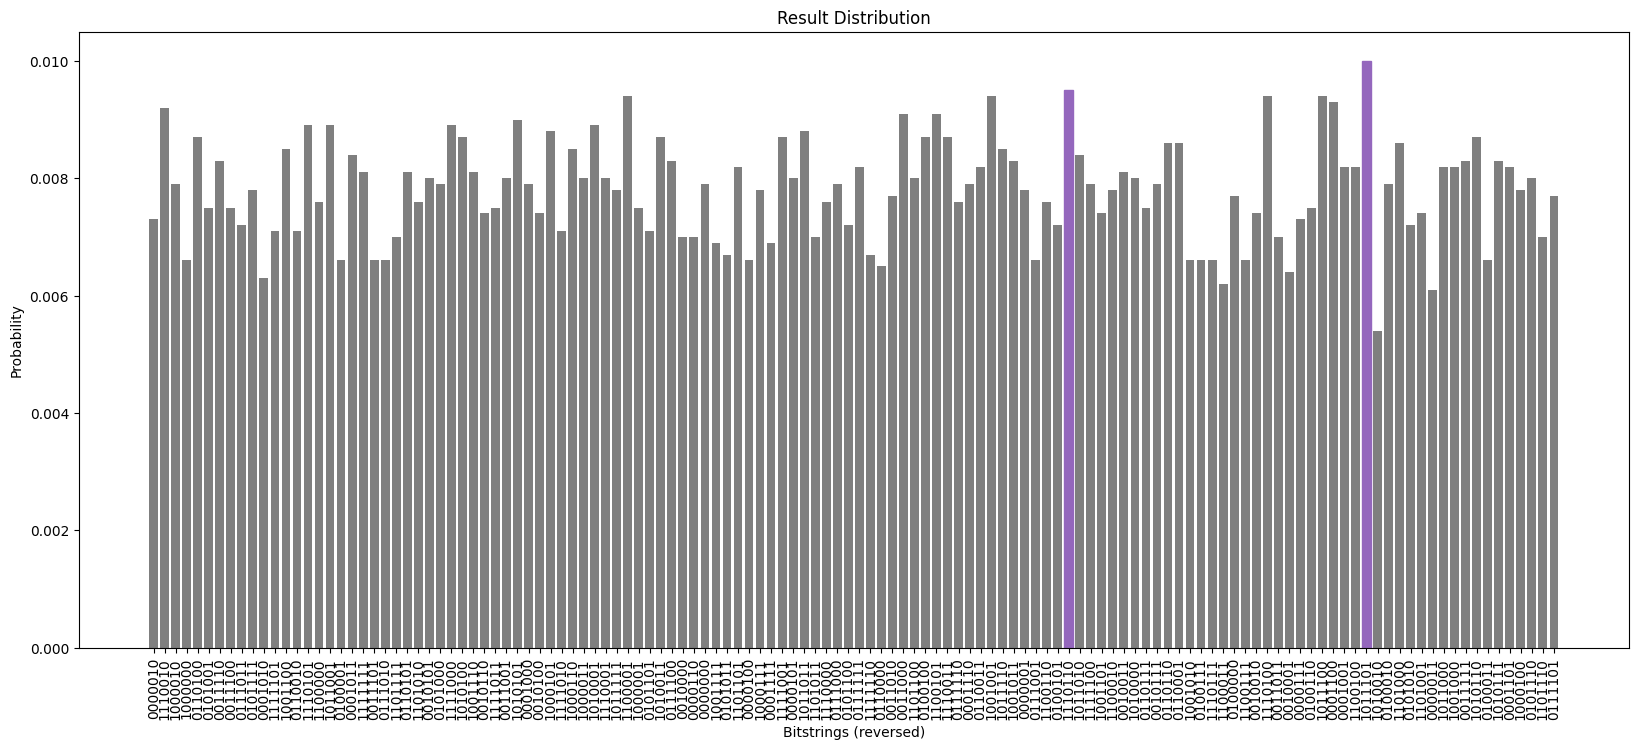

In [30]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=90)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

### Closing Notes

Apart from the brute force solution, and CPLEX (simplex method) not much emphasis has been put on reproducing another state-of-the-art classical optimisation algorithm in this notebook. Possible candidates considered were ***Tabu Search, MILP(Mixed-Integer Linear Programming), Simulated Annealing (can be seen as a special case of Tabu Search), and Gurobi Optimisation***. 

I spent a lot of time trying to implement a Tabu Search from scratch but couldn't reach successful completion. There were various, almost confusing variants of it in the available literature, with say, MATLAB implementing one kind, and DWave another, so I've ommitted it. I hope the emphasis on the Quantum Algorithms is the sufficient and important aspect, considering the time boundation.

Thank you for reading through!